# Regression analysis on custom dataset

### Authors

Britt Haanen
Pragay Shourya Moudgil

### Preamble

The code below imports the required packages.

In [ ]:
# Numpy
import numpy as np

# pandas
import pandas as pd
import geopandas as gpd

# scikit-learn
import sklearn
from sklearn import ensemble, neural_network
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, r2_score

#xgboost
from xgboost import XGBRegressor

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.basemap import Basemap

# tqdm
from tqdm import tqdm

#warnings
import warnings
warnings.filterwarnings('ignore')

# joblib
from joblib import Parallel, delayed


from IPython.display import clear_output

# json
import json

# seaborn
import seaborn as sns

#sys
import sys

#xarray
import xarray as xr

print("Python:", sys.version)
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Geopandas:", gpd.__version__)
print("Scikit-learn:", sklearn.__version__)
print("json:", json.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Seaborn:", sns.__version__)
print("Xarray:", xr.__version__)

Python: 3.8.17 | packaged by conda-forge | (default, Jun 16 2023, 07:06:00) 
[GCC 11.4.0]
NumPy: 1.23.5
Pandas: 2.0.3
Geopandas: 0.13.2
Scikit-learn: 1.3.0
json: 2.0.9
Matplotlib: 3.7.2
Seaborn: 0.12.2
Xarray: 0.21.0


## Data import and processing

This code imports the surface mass balance data and generates the associated plots for the Study Area section. It also performs the correlation analysis by plotting the correlation matrix. 

In [2]:
df = pd.read_csv('./input/input_data_smb.csv') # read the data
df.loc[df['POINT_BALANCE'] < -10000, 'POINT_BALANCE'] /= 10 # Due to error in the dataset having too large values (error in recording) the values are divided by 10 (Based on advice from the data provider)
df_copy = df.copy() # create a copy of the dataframe
df_copy.drop(columns=['time'], inplace=True) # drop the first column
df_copy = df_copy.groupby(['location', 'POINT_BALANCE']).mean(numeric_only = True) # group by location and point balance
df_copy.reset_index(inplace=True) # reset the index
df_copy = df_copy.set_index('location') # set the index

In [ ]:
unique_locations_df = df.reset_index().drop_duplicates(subset='location')[['POINT_LAT', 'POINT_LON']]
gdf = gpd.GeoDataFrame(unique_locations_df, geometry=gpd.points_from_xy(unique_locations_df.POINT_LON, unique_locations_df.POINT_LAT))
gdf.crs = 'EPSG:4326'

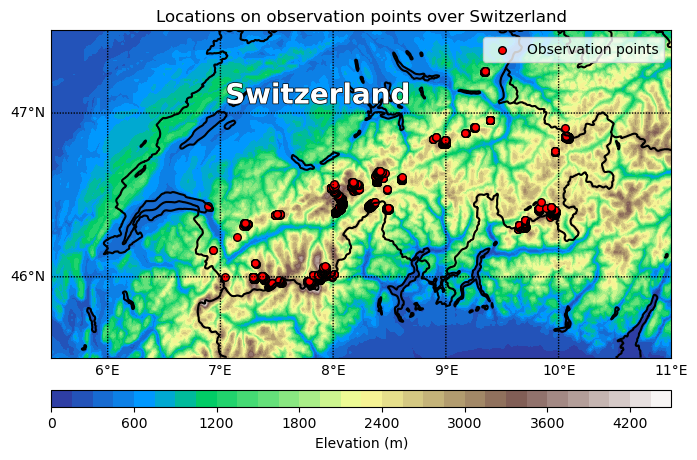

In [16]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Create a basemap instance
m = Basemap(projection='merc', llcrnrlat=45.5, urcrnrlat=47.5, llcrnrlon=5.5, urcrnrlon=11, resolution='f', ax=ax)
# Read the TIFF file
tiff_file = './ETOPO1_Bed_g_geotiff.tif'
tiff_data = xr.open_rasterio(tiff_file)

tiff_data = tiff_data.sel(band=1, x=slice(5, 12), y=slice(48, 45))

x, y = m(*np.meshgrid(tiff_data['x'], tiff_data['y']))



cs = m.contourf(x,y,tiff_data,30,cmap=cm.terrain)
x, y = m(unique_locations_df['POINT_LON'].values, unique_locations_df['POINT_LAT'].values)

# Plot the points on the map
m.scatter(x, y, marker='o', color='red', s = 30, edgecolor='k', label='Observation points')

m.drawcoastlines(color='k', linewidth=1.5)
m.drawcountries(color='k', linewidth=1.5)
m.drawcountries()
m.drawparallels(np.arange(45., 49., 1.), labels=[1,0,0,0])
m.drawmeridians(np.arange(5., 13., 1.), labels=[0,0,0,1])
m.drawstates()


# Add title
plt.title('Locations on observation points over Switzerland')
plt.legend()
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label('Elevation (m)')
# Add text inside the map
plt.text(0.43, 0.8, 'Switzerland',
         fontsize=20, 
         ha='center', 
         va='center', 
         color='white', 
         weight='bold', 
         path_effects=[matplotlib.patheffects.withStroke(linewidth=1, foreground='black')],
         transform=ax.transAxes)
plt.savefig('locations_map.png', bbox_inches='tight', dpi=600)
# Show the plot
plt.show()

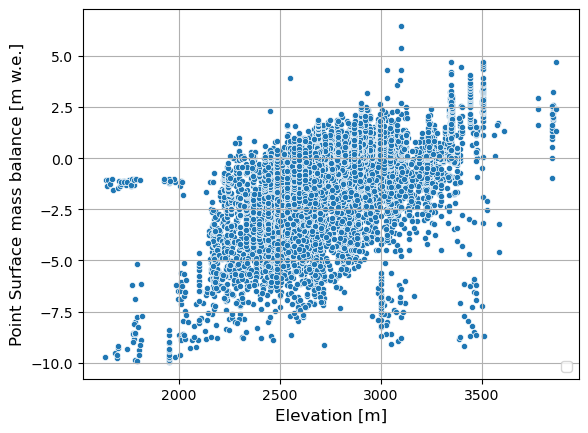

In [3]:
df_copy['POINT_BALANCE'] = df_copy['POINT_BALANCE']/1000 # convert the values to meters water equivalent

# Create a figure and axis
ax = sns.scatterplot(data=df_copy, x="POINT_ELEVATION", y="POINT_BALANCE",palette='Paired')
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, ['Summer', 'Winter'], loc='lower right')
ax.collections[0].set_sizes([20])                
ax.set_xlabel("Elevation [m]", fontsize=12)
ax.set_ylabel("Point Surface mass balance [m w.e.]", fontsize=12)
plt.grid()
plt.savefig('Elevation dependent Annual Surface Mass Balance.png', dpi = 600, bbox_inches='tight')

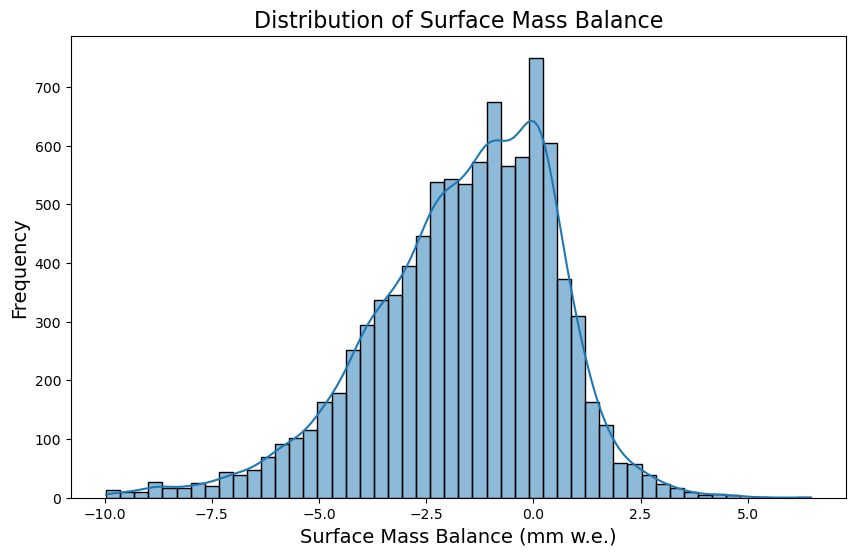

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df_copy['POINT_BALANCE'], bins=50, kde=True)
plt.title('Distribution of Surface Mass Balance', fontsize=16)
plt.xlabel('Surface Mass Balance (mm w.e.)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.savefig('./Figures/smb_distribution.png', bbox_inches='tight', dpi=600)
plt.show()

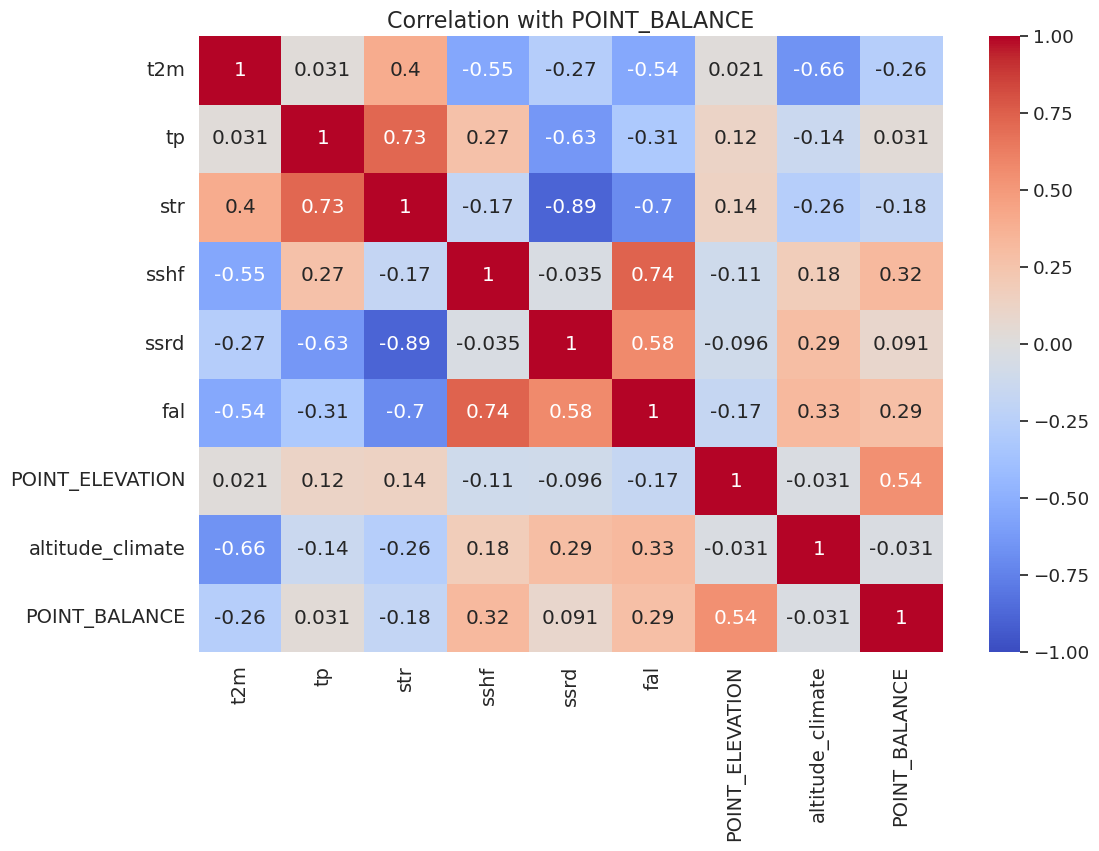

In [19]:
plt.figure(figsize=(12, 8))
correlation_matrix = df_copy[['t2m', 'tp', 'str', 'sshf', 'ssrd', 'fal', 'POINT_ELEVATION', 'altitude_climate', 'POINT_BALANCE']].corr()
sns.set(font_scale=1.2)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Correlation with POINT_BALANCE', fontsize=16)
plt.savefig('./Figures/correlation_matrix.png', bbox_inches='tight', dpi=600)
plt.show()

## Setup of test function

This code sets up the function that is used to test a particular model. It includes splitting of the data using, setup of the grid search, hyperparameter tuning, and computation of the evaluation metrics using scikit-learn. 

In [7]:
def test_models(df,
                input_variables,
                target_variable,
                model,
                test_size, 
                random_state,
                param_grid
                ):
    """
    Function that tests different models with different input variables
    and returns the results in a dataframe

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe with the data
    input_variables : list 
        The list of input variables
    target_variable : str
        The target variable
    model : sklearn model
        The model to test
    test_size : float
        The size of the test set
    random_state : int
        The random state

    Returns
    -------
    pd.DataFrame
        The dataframe with the results
    """
    
    results = []




    X = df[input_variables].values
    y = df[target_variable].values.reshape(-1, 1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    y_train = scaler.fit_transform(y_train)
    y_test = scaler.transform(y_test)


    # Define the grid search
    grid_search = GridSearchCV(estimator=model,
                                param_grid=param_grid,
                                cv=10, 
                                scoring='neg_mean_absolute_error', 
                                verbose=1, 
                                n_jobs=-1)

    # Fit the grid search
    grid_search.fit(X_train, np.ravel(y_train))

    # Get the best model
    best_model = grid_search.best_estimator_


    # Predict and evaluate the model
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)

    # Inverse transform the scaled data
    y_pred_train_inv = scaler.inverse_transform(y_pred_train.reshape(-1, 1))
    y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1, 1))
    y_train_inv = scaler.inverse_transform(y_train)
    y_test_inv = scaler.inverse_transform(y_test)

    # Calculate metrics
    train_corr = np.corrcoef(y_train_inv.flatten(), y_pred_train_inv.flatten())[0, 1]
    test_corr = np.corrcoef(y_test_inv.flatten(), y_pred_test_inv.flatten())[0, 1]
    train_mae = mean_absolute_error(y_train_inv, y_pred_train_inv)
    test_mae = mean_absolute_error(y_test_inv, y_pred_test_inv)
    train_r2 = r2_score(y_train_inv, y_pred_train_inv)
    test_r2 = r2_score(y_test_inv, y_pred_test_inv)

    # Append results
    results.append({
        'input_vars': input_variables,
        'model': model.__class__.__name__,
        'train_corr': train_corr,
        'test_corr': test_corr,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'train_r2': train_r2,
        'test_r2': test_r2
    })

    return pd.DataFrame(results)
    

## Definition of models

This code sets up the inputs for the models and the models themselves. Linear Regression, Ridge Regression, Random Forest, and MLP Regressor (ANN) are set up using scikit-learn. The XGBoost model is defined using the xgboost module.

In [ ]:
# Define the input variables
input_variables = ['t2m', 'tp', 'str', 'sshf', 'ssrd', 'fal', 'POINT_ELEVATION', 'altitude_climate']

# Generate incremental combinations of input variables
combinations = [input_variables[:i+1] for i in range(len(input_variables))]

# Define the models and their hyperparameters
models = [
    (linear_model.LinearRegression(), 'OLS', {}),
    (linear_model.Ridge(), 'Ridge', {'alpha': [0.1, 1.0, 10.0]}),
    (ensemble.RandomForestRegressor(), 'RandomForest', {'n_estimators': [100, 200], 'max_depth': [10, 20]}),
    (XGBRegressor(), 'XGBoost', {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 6]}),
    (neural_network.MLPRegressor(max_iter=1000), 'ANN', {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'activation': ['relu', 'tanh'], 'solver': ['adam', 'sgd']})
]

## Generation of results

This code implements the test function to test all models across various inputs. The results are stored, exported numerically for tables and plotted as box plots using matplotlib.

In [ ]:
results = []

for combo in tqdm(combinations, desc='Combinations'):
    for model, model_name, param_grid in models:
        result = test_models(df=df_copy,
                             input_variables=combo,
                             target_variable='POINT_BALANCE',
                             model=model,
                             test_size=0.2,
                             random_state=42,
                             param_grid=param_grid)
        results.append((combo, model_name, result))
    clear_output(wait=True)

results_df = pd.concat([result for _, _, result in results])
results_df.replace('MLPRegressor', 'ANN', inplace=True)
results_df.to_csv('./results.csv', index=False)

Combinations: 100%|██████████| 8/8 [33:29<00:00, 251.19s/it]


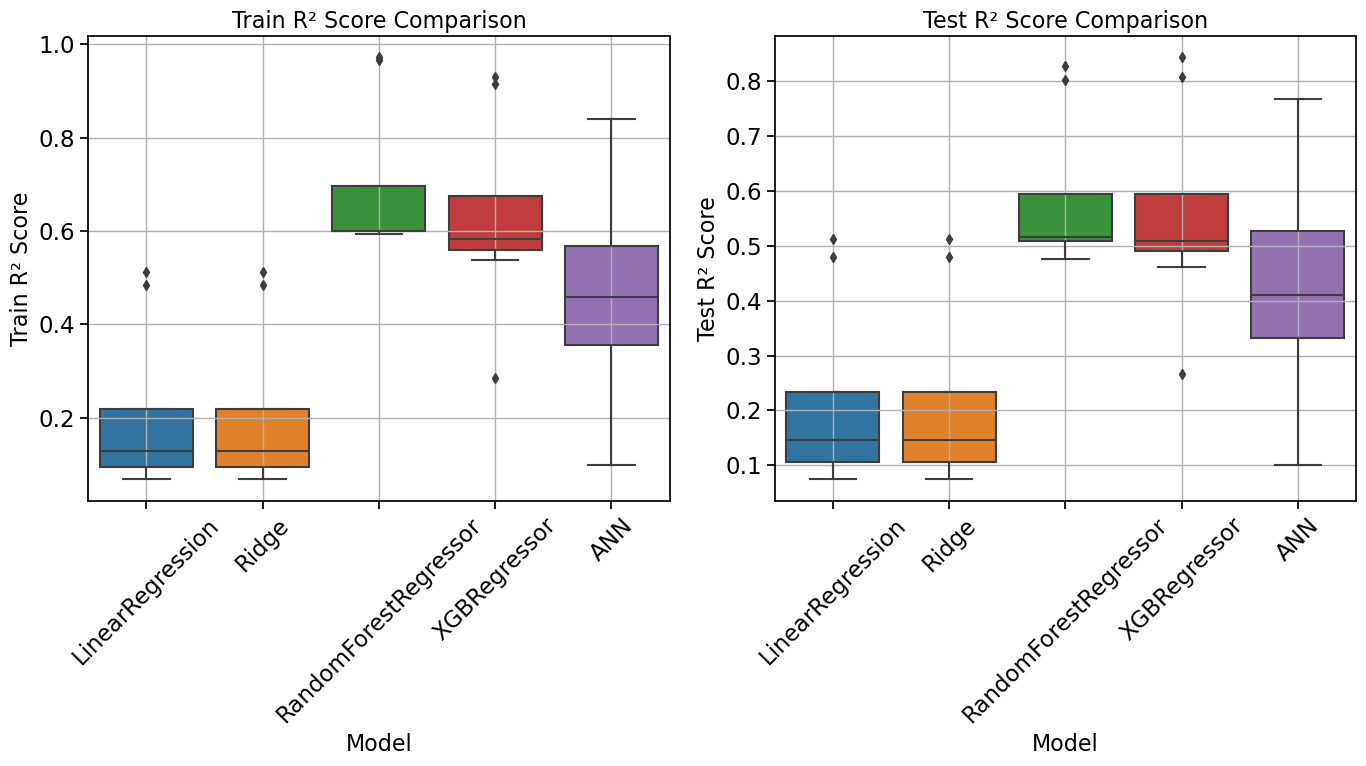

In [9]:
plt.figure(figsize=(14, 8))

sns.set_context("notebook", font_scale=1.5)
# Plot train R² scores
plt.subplot(1, 2, 1)
sns.boxplot(x='model', y='train_r2', data=results_df)
plt.title('Train R² Score Comparison', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Train R² Score', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)

# Plot test R² scores
plt.subplot(1, 2, 2)
sns.boxplot(x='model', y='test_r2', data=results_df)
plt.title('Test R² Score Comparison', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Test R² Score', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('./Figures/model_comparison.png', bbox_inches='tight', dpi=600)

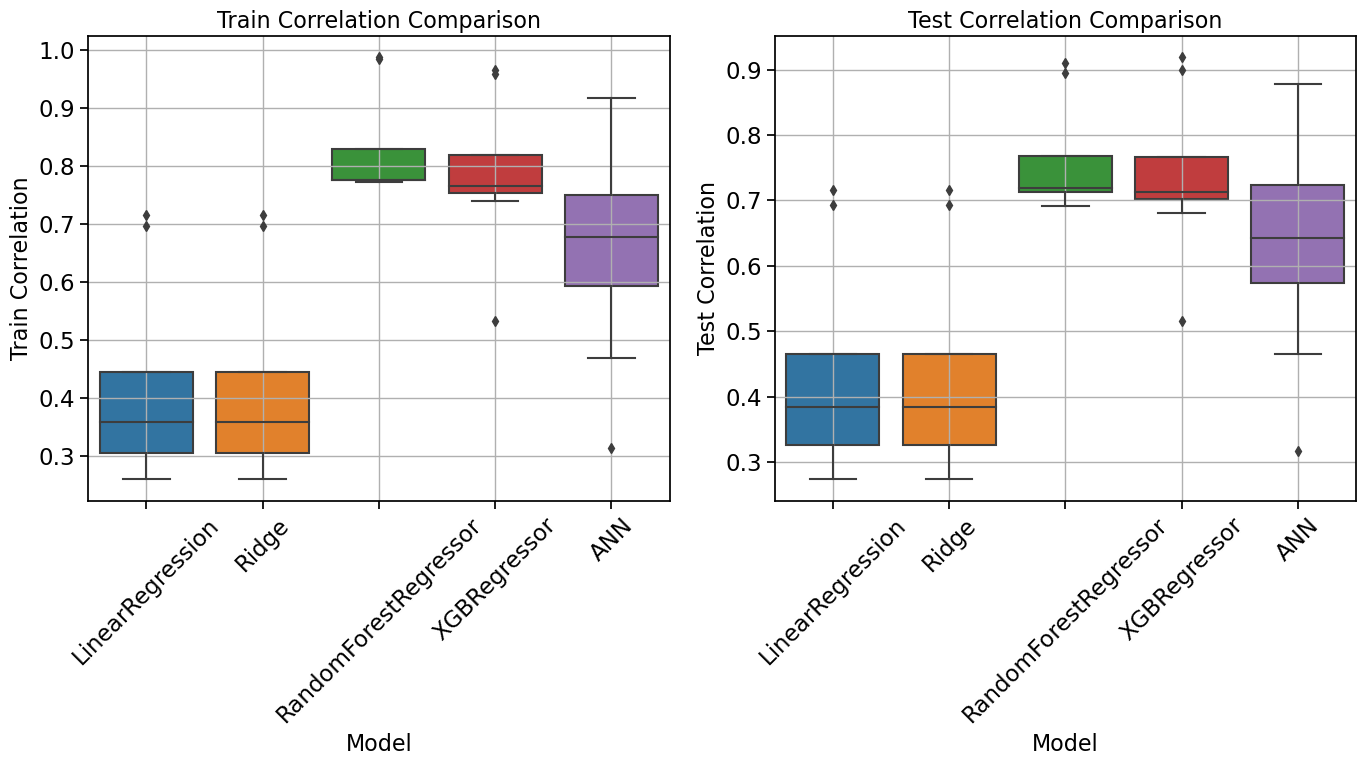

In [10]:
plt.figure(figsize=(14, 8))

sns.set_context("notebook", font_scale=1.5)
# Plot train R² scores
plt.subplot(1, 2, 1)
sns.boxplot(x='model', y='train_corr', data=results_df)
plt.title('Train Correlation Comparison', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Train Correlation', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)

# Plot test R² scores
plt.subplot(1, 2, 2)
sns.boxplot(x='model', y='test_corr', data=results_df)
plt.title('Test Correlation Comparison', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Test Correlation', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('./Figures/model_comparison_corr.png', bbox_inches='tight', dpi=600)

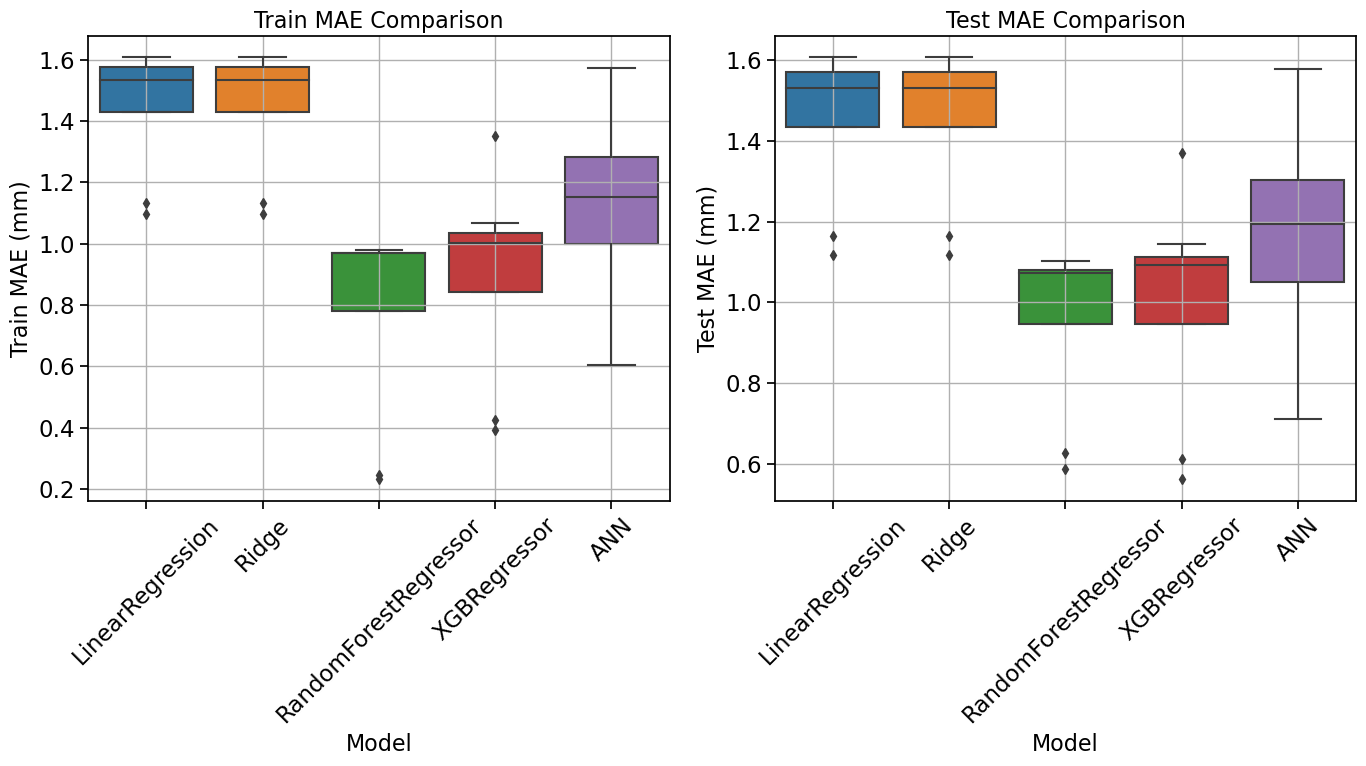

In [11]:
plt.figure(figsize=(14, 8))

sns.set_context("notebook", font_scale=1.5)
# Plot train R² scores
plt.subplot(1, 2, 1)
sns.boxplot(x='model', y='train_mae', data=results_df)
plt.title('Train MAE Comparison', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Train MAE (mm)', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)

# Plot test R² scores
plt.subplot(1, 2, 2)
sns.boxplot(x='model', y='test_mae', data=results_df)
plt.title('Test MAE Comparison', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.ylabel('Test MAE (mm)', fontsize=16)
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.savefig('./Figures/model_comparison_mae.png', bbox_inches='tight', dpi=600)